In [1]:
%load_ext autoreload
%autoreload 2
%pdb
%matplotlib inline

Automatic pdb calling has been turned ON


In [2]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
from collections import defaultdict, OrderedDict

from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data

## Load covid19 data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data', 'df_raw_data_2', 'df_travel_history', 'df_resources'])

In [5]:
df_district = get_district_time_series(dataframes)

## Create train-val splits

In [6]:
df_train = df_district.iloc[:-5, :]
df_val = df_district.iloc[-5:, :]

## Loss Calculation Functions

In [7]:
def _calc_rmse(y_pred, y_true, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_pred, y_true):
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
#     losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
#     losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
#     losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
#     losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['total_infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
#     loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    loss = losses['total']
    return loss

## Set priors for parameters of interest

In [104]:
## assuming uniform priors, following dictionary contains the ranges
prior_ranges = OrderedDict()
prior_ranges['R0'] = (1, 3)#(1.6, 3)
prior_ranges['T_inc'] = (1, 5) #(4, 5)
prior_ranges['T_inf'] = (1, 4) #(3, 4)
prior_ranges['T_recov_severe'] = (9, 20)
prior_ranges['P_severe'] = (0.3, 0.99)
prior_ranges['intervention_amount'] = (0.3, 1)
prior_ranges['c_sigma'] = (0, 5)

def param_init():
    theta = defaultdict()
    for key in prior_ranges:
        theta[key] = np.random.uniform(prior_ranges[key][0], prior_ranges[key][1])
        
    return theta

## Proposal function to sample theta_new given theta_old

In [105]:
proposal_sigmas = OrderedDict()
for key in prior_ranges:
    proposal_sigmas[key] = 0.25 * (prior_ranges[key][1] - prior_ranges[key][0])

def proposal(theta_old):
    theta_new = np.random.normal(loc=[*theta_old.values()], scale=[*proposal_sigmas.values()])
    return dict(zip(theta_old.keys(), theta_new))


## Log Likelihood and Prior

In [106]:
def log_likelihood(theta):
    if (np.array([*theta.values()]) < 0).any():
        return -np.inf
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(df_train)
    df_prediction = optimiser.solve(theta, default_params, df_train)
    pred = np.array(df_prediction['total_infected'])
    true = np.array(df_train['total_infected'])
#     alpha = theta['c_sigma']
#     sigma = alpha * true.std()
    sigma = theta['c_sigma']
    N = len(true)
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
    return ll

def log_prior(theta):
#     prior = 1
#     for key in prior_ranges:
#         if in_valid_range(key, theta[key]):
#             prior *= 1 / (prior_ranges[key][1] - prior_ranges[key][0])
#         else:
#             prior = 0
#             break
    if (np.array([*theta.values()]) < 0).any():
        prior = 0
    else:
        prior = 1
    
    return np.log(prior)

def in_valid_range(key, value):
    return (value <= prior_ranges[key][1]) and (value >= prior_ranges[key][0])

## Acceptance function

In [107]:
def accept(theta_old, theta_new):    
    x_new = log_likelihood(theta_new) + log_prior(theta_new)
    x_old = log_likelihood(theta_old) + log_prior(theta_old)
    
    if (x_new) > (x_old):
        return True
    else:
        x = np.random.uniform(0, 1)
        return (x < np.exp(x_new - x_old))
    
def anneal_accept(iter):
    prob = 1 - np.exp(-(1/(iter + 1e-10)))
    x = np.random.uniform(0, 1)
    return (x < prob)

## Metropolis loop

In [108]:
def metropolis(iter=1000):
    theta = param_init()
    accepted = [theta]
    rejected = list()
    
    for i in tqdm(range(iter)):
        theta_new = proposal(theta)
        if anneal_accept(i):
            theta = theta_new
        else:
            if accept(theta, theta_new):
                theta = theta_new
            else:
                rejected.append(theta_new)
        accepted.append(theta)
    
    return accepted, rejected

In [109]:
acc, rej = metropolis(iter=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-106-2f752f5c7d84>:29: RuntimeWarning: divide by zero encountered in log
  return np.log(prior)
<ipython-input-107-4f74e3f06f37>:9: RuntimeWarning: invalid value encountered in double_scalars
  return (x < np.exp(x_new - x_old))
100%|██████████| 10000/10000 [05:53<00:00, 28.29it/s]


In [110]:
df_samples = pd.DataFrame(acc)

In [111]:
df_samples

,R0,T_inc,T_inf,T_recov_severe,P_severe,intervention_amount,c_sigma
0,2.647875,4.470988,1.027264,18.397364,0.980810,0.548226,4.246712
1,2.391274,2.614841,0.384478,18.447052,0.979760,0.636405,3.221558
2,2.116295,0.541085,0.547262,15.591236,0.829576,0.370767,1.727336
3,3.092908,2.541702,0.579919,12.831328,0.687469,0.336946,3.334867
4,3.352652,1.767098,-0.487559,10.642169,1.013168,0.198388,2.814470
...,...,...,...,...,...,...,...
9996,1.596377,3.602455,3.270474,9.534612,5.458834,0.616659,3.684637
9997,1.596377,3.602455,3.270474,9.534612,5.458834,0.616659,3.684637
9998,1.596377,3.602455,3.270474,9.534612,5.458834,0.616659,3.684637
9999,1.596377,3.602455,3.270474,9.534612,5.458834,0.616659,3.684637


Text(0.5, 1.0, 'Parameter samples obtained from MCMC')

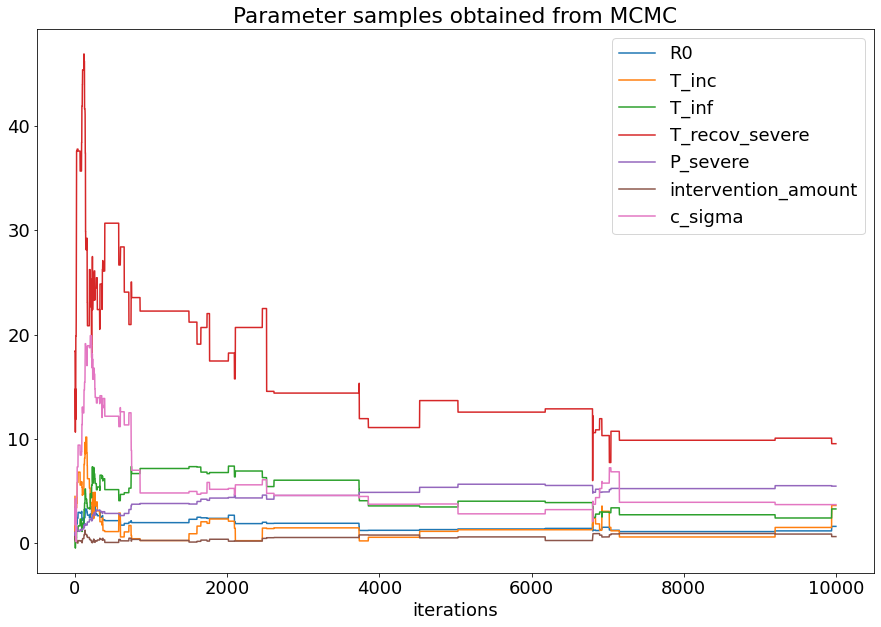

In [112]:
plt.figure(figsize=(15, 10))
for param in df_samples.columns:
    plt.plot(list(range(len(df_samples[param]))), df_samples[param], label=param)
plt.xlabel("iterations")
plt.legend()
plt.title("Parameter samples obtained from MCMC")

In [113]:
rej_samples = pd.DataFrame(rej)

Text(0.5, 1.0, 'Rejected Parameter samples obtained from MCMC')

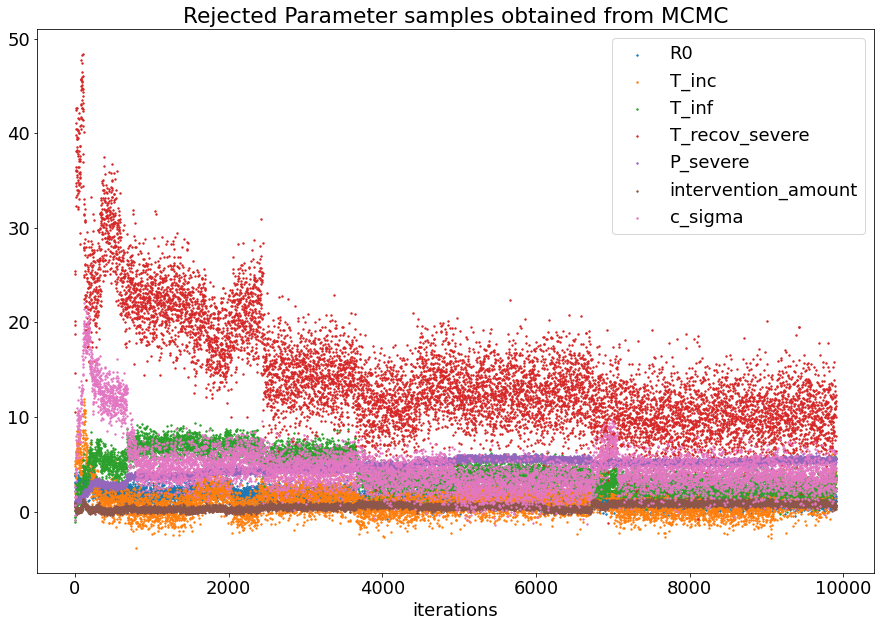

In [114]:
plt.figure(figsize=(15, 10))
for param in rej_samples.columns:
    plt.scatter(list(range(len(rej_samples[param]))), rej_samples[param], label=param, s=2)
plt.xlabel("iterations")
plt.legend()
plt.title("Rejected Parameter samples obtained from MCMC")

(array([3749., 1736.,  723.,   58.,   52., 1641.,  857.,  195.,  153.,
         495.,    9.,  157.,   58.,   32.,   23.,   20.,   12.,   11.,
          13.,    7.]),
 array([1.09709327, 1.23527596, 1.37345865, 1.51164134, 1.64982403,
        1.78800673, 1.92618942, 2.06437211, 2.2025548 , 2.34073749,
        2.47892019, 2.61710288, 2.75528557, 2.89346826, 3.03165096,
        3.16983365, 3.30801634, 3.44619903, 3.58438172, 3.72256442,
        3.86074711]),
 <a list of 20 Patch objects>)

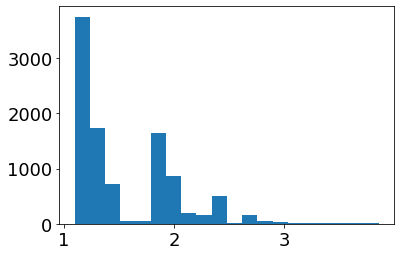

In [115]:
plt.hist(df_samples['R0'], bins=20)

## Use samples to estimate confidence intervals

In [116]:
data_split = df_train.copy()
optimiser = Optimiser()
default_params = optimiser.init_default_params(data_split)

In [117]:
burn_in = int(len(acc) / 2)
n_samples = 1000
posterior_samples = acc[burn_in:]
sample_indices = np.random.uniform(0, len(posterior_samples), n_samples)

pred_dfs = list()
for i in tqdm(sample_indices):
    pred_dfs.append(optimiser.solve(posterior_samples[int(i)], default_params, data_split))

100%|██████████| 1000/1000 [00:17<00:00, 55.83it/s]


In [118]:
for df in pred_dfs:
    df.set_index('date', inplace=True)

In [119]:
result = pred_dfs[0].copy()
for col in result.columns:
    result["{}_low".format(col)] = ''
    result["{}_high".format(col)] = ''

In [120]:
def get_PI(date, key, multiplier=1.96):
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
        
    mu = np.array(pred_samples).mean()
    sigma = np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

In [121]:
for date in tqdm(pred_dfs[0].index):
    for key in pred_dfs[0]:
        result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(date, key)

100%|██████████| 43/43 [00:06<00:00,  7.16it/s]


## Visualize the intervals

Text(0.5, 1.0, '95% confidence intervals')

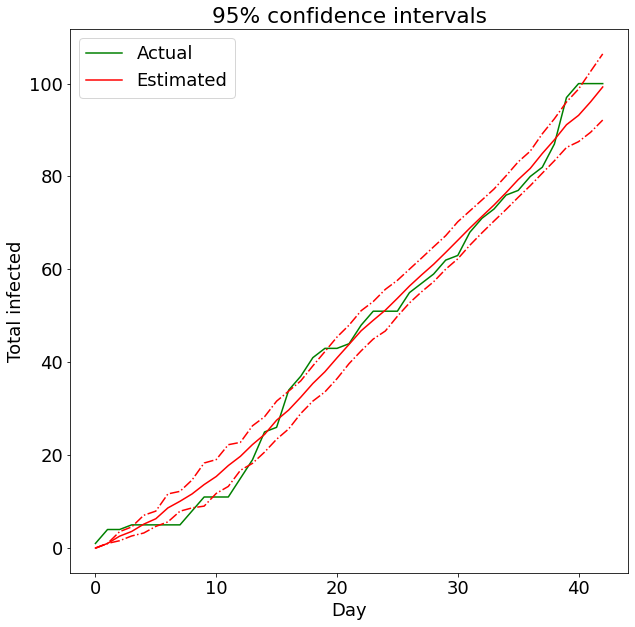

In [122]:
data_split.set_index("date", inplace=True)
plt.figure(figsize=(10, 10))
plt.plot(data_split['total_infected'].tolist(), c='g', label='Actual')
plt.plot(result['total_infected'].tolist(), c='r', label='Estimated')
plt.plot(result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
plt.plot(result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
plt.xlabel("Day")
plt.ylabel("Total infected")
plt.legend()
plt.title("95% confidence intervals")